In [1]:
from pyspark.sql import SparkSession

In [3]:
import os
# Set JAVA_HOME to the correct Java installation path
os.environ['JAVA_HOME'] = '/opt/homebrew/Cellar/openjdk@17/17.0.17/libexec/openjdk.jdk/Contents/Home'


In [4]:
# Create SparkSession
spark = SparkSession.builder.appName("Spark SQL Query Dataframes").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/22 19:00:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/22 19:00:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/12/22 19:00:11 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [5]:
data_path = '/Users/zlatavorobeva/Documents/GitHub/SQL Int/SQL_Intermediate/Spark/Data'

In [6]:
json_df2_path = data_path + "/utilization.json"
df_util = spark.read.format("json").load(json_df2_path)

In [7]:
df_util.show(10)

+---------------+-------------------+-----------+---------+-------------+
|cpu_utilization|     event_datetime|free_memory|server_id|session_count|
+---------------+-------------------+-----------+---------+-------------+
|           0.57|03/05/2019 08:06:14|       0.51|      100|           47|
|           0.47|03/05/2019 08:11:14|       0.62|      100|           43|
|           0.56|03/05/2019 08:16:14|       0.57|      100|           62|
|           0.57|03/05/2019 08:21:14|       0.56|      100|           50|
|           0.35|03/05/2019 08:26:14|       0.46|      100|           43|
|           0.41|03/05/2019 08:31:14|       0.58|      100|           48|
|           0.57|03/05/2019 08:36:14|       0.35|      100|           58|
|           0.41|03/05/2019 08:41:14|        0.4|      100|           58|
|           0.53|03/05/2019 08:46:14|       0.35|      100|           62|
|           0.51|03/05/2019 08:51:14|        0.6|      100|           45|
+---------------+-------------------+-

In [8]:
df_util.createOrReplaceTempView("utilization")

In [9]:
df_util.count()

500000

In [10]:
df_util.describe().show()

25/12/22 19:00:47 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+-------------------+-------------------+------------------+------------------+
|summary|    cpu_utilization|     event_datetime|        free_memory|         server_id|     session_count|
+-------+-------------------+-------------------+-------------------+------------------+------------------+
|  count|             500000|             500000|             500000|            500000|            500000|
|   mean| 0.6205177399999957|               NULL|0.37912809999999864|             124.5|          69.59616|
| stddev|0.15875173872912945|               NULL|0.15830931278376276|14.430884120553191|14.850676696352851|
|    min|               0.22|03/05/2019 08:06:14|                0.0|               100|                32|
|    max|                1.0|04/09/2019 01:22:46|               0.78|               149|               105|
+-------+-------------------+-------------------+-------------------+------------------+------------------+



In [11]:
df_util.describe('cpu_utilization','free_memory').show()

+-------+-------------------+-------------------+
|summary|    cpu_utilization|        free_memory|
+-------+-------------------+-------------------+
|  count|             500000|             500000|
|   mean| 0.6205177399999957|0.37912809999999864|
| stddev|0.15875173872912945|0.15830931278376276|
|    min|               0.22|                0.0|
|    max|                1.0|               0.78|
+-------+-------------------+-------------------+



In [12]:
df_util.stat.corr('cpu_utilization','free_memory')

-0.47047715730807554

In [13]:
df_util.stat.corr('session_count','free_memory')

-0.5008320848876574

In [14]:
df_util.stat.freqItems(('server_id','session_count')).show()

+--------------------+-----------------------+
| server_id_freqItems|session_count_freqItems|
+--------------------+-----------------------+
|[128, 129, 130, 1...|   [32, 33, 34, 35, ...|
+--------------------+-----------------------+



In [16]:
df_util_sample = df_util.sample(fraction=0.05, withReplacement=False)
df_util_sample.count()

25197

In [17]:
spark.sql('SELECT min(cpu_utilization), max(cpu_utilization), stddev(cpu_utilization) FROM utilization').show()

+--------------------+--------------------+-----------------------+
|min(cpu_utilization)|max(cpu_utilization)|stddev(cpu_utilization)|
+--------------------+--------------------+-----------------------+
|                0.22|                 1.0|    0.15875173872912945|
+--------------------+--------------------+-----------------------+



In [18]:
spark.sql('SELECT server_id, min(cpu_utilization), max(cpu_utilization), stddev(cpu_utilization) \
           FROM utilization \
           GROUP BY server_id').show()

+---------+--------------------+--------------------+-----------------------+
|server_id|min(cpu_utilization)|max(cpu_utilization)|stddev(cpu_utilization)|
+---------+--------------------+--------------------+-----------------------+
|      103|                0.56|                0.96|    0.11617507884178278|
|      104|                0.51|                0.91|    0.11521679513850511|
|      106|                0.22|                0.62|    0.11531539914568226|
|      100|                0.27|                0.67|     0.1152264191787964|
|      105|                0.29|                0.69|    0.11510721467869486|
|      101|                 0.6|                 1.0|    0.11651726263197697|
|      102|                0.56|                0.96|    0.11549678751286807|
|      112|                0.52|                0.92|    0.11528867845082576|
|      113|                0.58|                0.98|    0.11544345150353687|
|      110|                0.35|                0.75|    0.11533

In [19]:
spark.sql('SELECT server_id, FLOOR(cpu_utilization*100/10) bucket FROM utilization').show()

+---------+------+
|server_id|bucket|
+---------+------+
|      100|     5|
|      100|     4|
|      100|     5|
|      100|     5|
|      100|     3|
|      100|     4|
|      100|     5|
|      100|     4|
|      100|     5|
|      100|     5|
|      100|     3|
|      100|     6|
|      100|     6|
|      100|     5|
|      100|     2|
|      100|     4|
|      100|     4|
|      100|     6|
|      100|     4|
|      100|     5|
+---------+------+
only showing top 20 rows


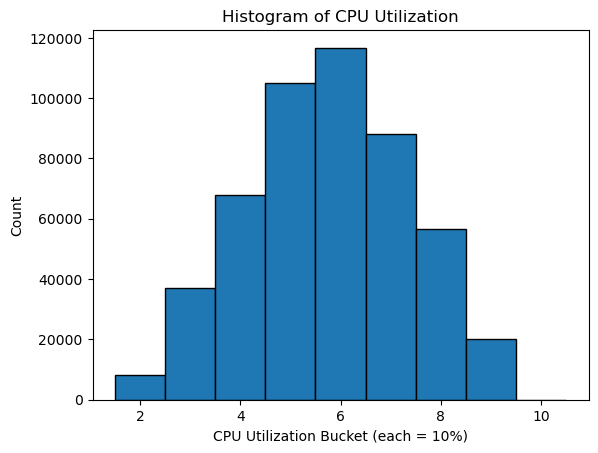

In [ ]:
import matplotlib.pyplot as plt

hist_data = spark.sql("""
    SELECT FLOOR(cpu_utilization*100/10) AS bucket, COUNT(*) AS count
    FROM utilization
    GROUP BY bucket
    ORDER BY bucket
""").toPandas()

plt.bar(hist_data['bucket'], hist_data['count'], width=1, edgecolor='black')
plt.xlabel('CPU Utilization Bucket (each = 10%)')
plt.ylabel('Count')
plt.title('Histogram of CPU Utilization')
plt.show()

In [21]:
spark.sql('SELECT count(*), FLOOR(cpu_utilization*100/10) bucket FROM utilization GROUP BY bucket ORDER BY bucket').show()

+--------+------+
|count(1)|bucket|
+--------+------+
|    8186|     2|
|   37029|     3|
|   68046|     4|
|  104910|     5|
|  116725|     6|
|   88242|     7|
|   56598|     8|
|   20207|     9|
|      57|    10|
+--------+------+

